In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.1 Load Data**

In [ ]:
!mkdir -p /content/fraud_dataset

In [ ]:
!ls -la /content/fraud_dataset


total 1323224
drwxr-xr-x 2 root root      4096 Mar 29 10:56 .
drwxr-xr-x 1 root root      4096 Mar 29 10:56 ..
-rw------- 1 root root   6080314 Mar 29 10:56 sample_submission.csv
-rw------- 1 root root  25797161 Mar 29 10:56 test_identity.csv
-rw------- 1 root root 613194934 Mar 29 10:56 test_transaction.csv
-rw------- 1 root root  26529680 Mar 29 10:56 train_identity.csv
-rw------- 1 root root 683351067 Mar 29 10:56 train_transaction.csv


In [ ]:
!cp /content/drive/MyDrive/ieee-fraud-detection/*.csv /content/fraud_dataset/

In [3]:
# Load transaction and identity datasets
transaction_data = pd.read_csv("fraud_dataset/train_transaction.csv")
identity_data = pd.read_csv("fraud_dataset/train_identity.csv")

In [4]:
# Merge datasets on 'TransactionID' (left join to keep all transactions)
data = transaction_data.merge(identity_data, on="TransactionID", how="left")

In [ ]:
# Display basic info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
None
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                

In [5]:
# print number of fraudulent and non fraudulent cases
data['isFraud'].value_counts()

,count
isFraud,
0,569877
1,20663


# **1.2 Handle missing values**

In [5]:
# Calculate missing value percentage
missing_percent = data.isnull().sum() * 100 / len(data)
print(missing_percent)

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
                    ...    
id_36             76.126088
id_37             76.126088
id_38             76.126088
DeviceType        76.155722
DeviceInfo        79.905510
Length: 434, dtype: float64


In [6]:
threshold = 50

# Drop columns with more than 50% missing values
columns_to_drop = missing_percent[missing_percent > threshold].index
print(columns_to_drop)

data.drop(columns=columns_to_drop, axis=1, inplace=True)

Index(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12',
       'D13',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=214)


In [8]:
# Fill missing numerical values with median
for col in data.select_dtypes(include=["float64", "int64"]).columns:
    data.fillna({col: data[col].median()}, inplace=True)

# Fill missing categorical values with mode
for col in data.select_dtypes(include=["object"]).columns:
    data.fillna({col: data[col].mode()[0]}, inplace=True)


Why Median?

- less sensitive to outliers compared to the mean.
Many transaction-related features (e.g., TransactionAmt) have skewed distributions. The median provides a better central value without being affected by extreme fraud transactions.

# **1.3 Data Exploration**

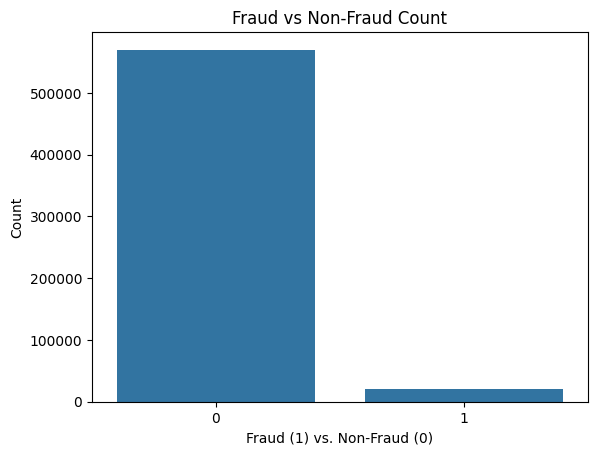

In [ ]:
# Count of fraud vs. non-fraud transactions
sns.countplot(x=data["isFraud"])
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("Fraud (1) vs. Non-Fraud (0)")
plt.ylabel("Count")
plt.show()

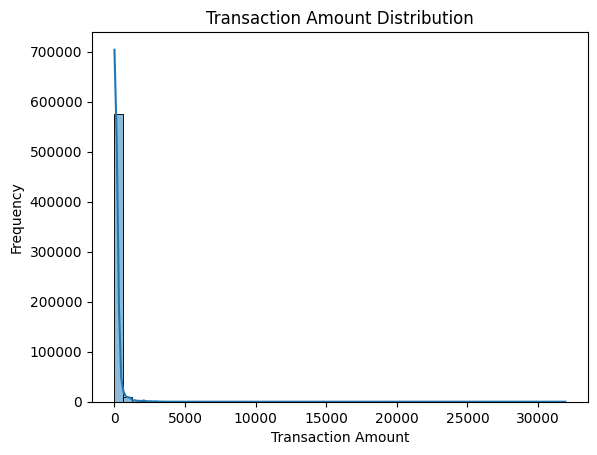

In [ ]:
sns.histplot(data["TransactionAmt"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


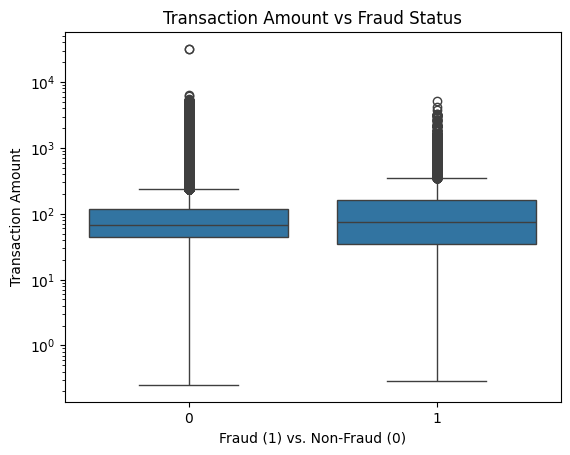

In [ ]:
sns.boxplot(x=data["isFraud"], y=data["TransactionAmt"])
plt.title("Transaction Amount vs Fraud Status")
plt.xlabel("Fraud (1) vs. Non-Fraud (0)")
plt.ylabel("Transaction Amount")
plt.yscale("log")  # Log scale for better visibility of outliers
plt.show()


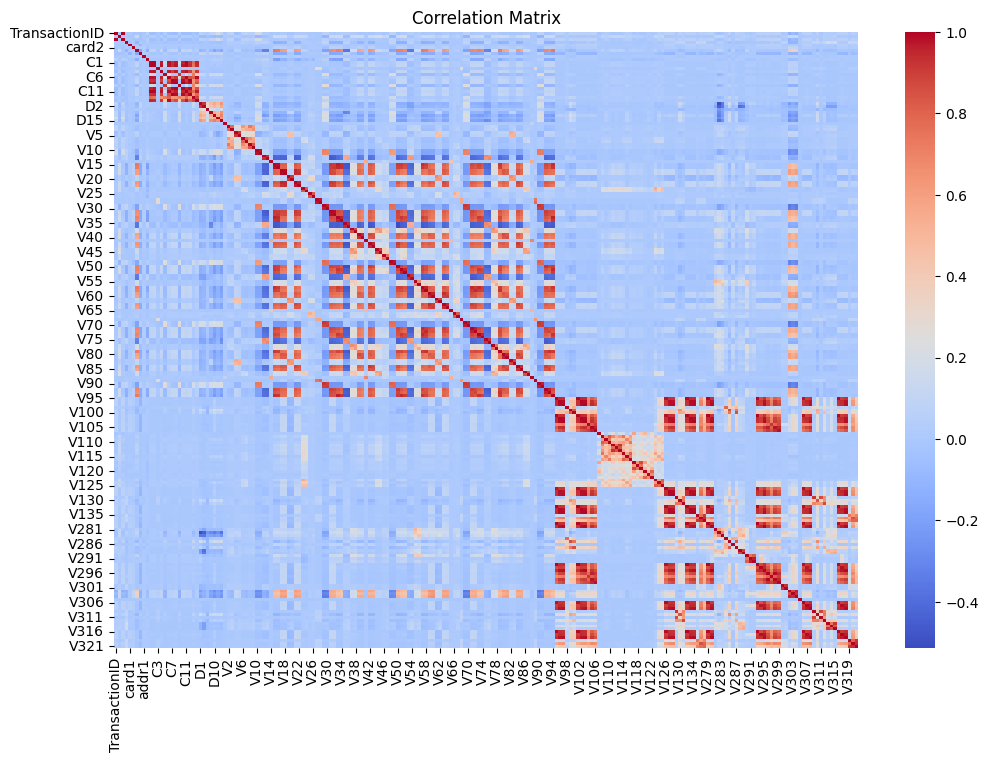

In [ ]:
# Select only numeric features for correlation calculation
numeric_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


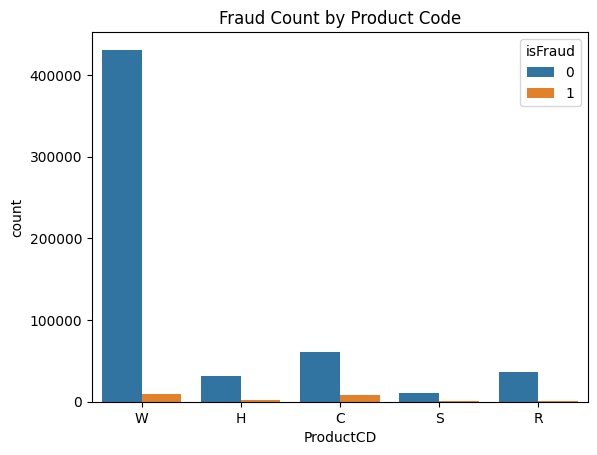

In [ ]:
sns.countplot(x="ProductCD", hue="isFraud", data=data)
plt.title("Fraud Count by Product Code")
plt.show()


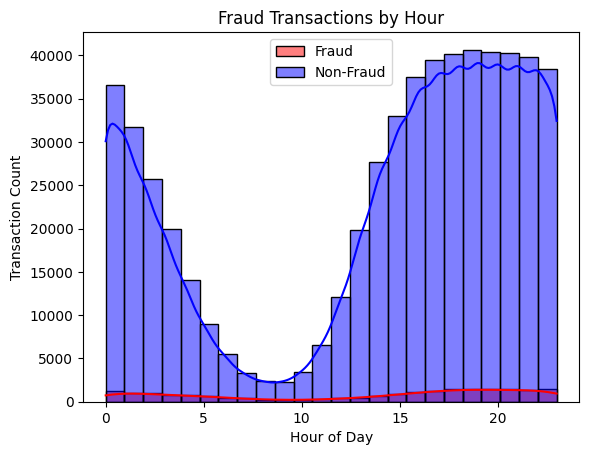

In [ ]:
data["TransactionHour"] = (data["TransactionDT"] // 3600) % 24  # Extract hour

sns.histplot(data[data["isFraud"] == 1]["TransactionHour"], bins=24, kde=True, color="red", label="Fraud")
sns.histplot(data[data["isFraud"] == 0]["TransactionHour"], bins=24, kde=True, color="blue", label="Non-Fraud", alpha=0.5)
plt.title("Fraud Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.legend()
plt.show()


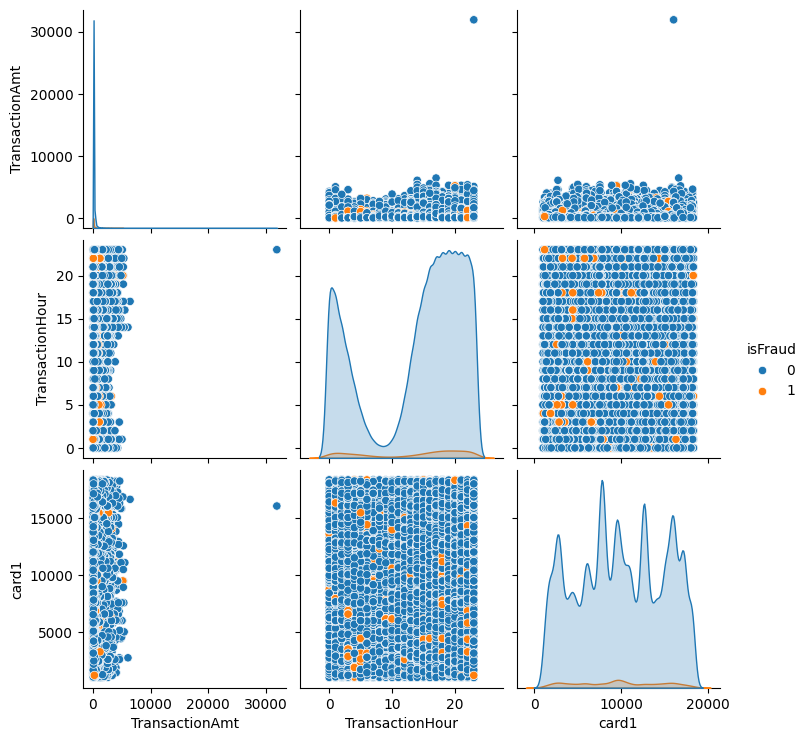

In [ ]:
selected_features = ["TransactionAmt", "TransactionHour", "card1", "isFraud"]
sns.pairplot(data[selected_features], hue="isFraud", diag_kind="kde")
plt.show()
# do not run.

In [7]:
print(len(data.columns))

220


# **1.4 Feature Engineering**

In [8]:
# Convert TransactionDT into hours and days
data["TransactionHour"] = (data["TransactionDT"] // 3600) % 24
data["TransactionDay"] = (data["TransactionDT"] // (3600 * 24)) % 7

# Drop the original TransactionDT column since it's not the actual timestamp
data.drop(columns=["TransactionDT"], inplace=True)


In [9]:
# Mean Transaction Amount per Card
data["Mean_TransactionAmt_per_Card"] = data.groupby("card1")["TransactionAmt"].transform("mean")

# Standard Deviation of Transaction Amount per Card
data["Std_TransactionAmt_per_Card"] = data.groupby("card1")["TransactionAmt"].transform("std")

# Number of Transactions per Card
data["Transaction_Frequency_per_Card"] = data.groupby("card1")["TransactionID"].transform("count")

# Fill NaN values in aggregated columns
data.fillna(0, inplace=True)



In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ["card1", "card2", "card3", "card5"]:  # high cardinality
    data[col] = data[col].fillna("NA")
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# One-hot encode the lower-cardinality features
low_cardinality = ["ProductCD", "card4", "card6"]
data = pd.get_dummies(data, columns=low_cardinality, drop_first=True)


In [10]:
from sklearn.model_selection import train_test_split

# Step 1: Separate features and target
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

# Step 2: Train-test split (stratify to preserve class ratio in test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Step 3: Balance ONLY the training data
train_data = pd.concat([X_train, y_train], axis=1)
fraud_data = train_data[train_data['isFraud'] == 1]
non_fraud_data = train_data[train_data['isFraud'] == 0]

# Undersample example
non_fraud_undersampled_data = non_fraud_data.sample(n=len(fraud_data), random_state=42)
balanced_train_data = pd.concat([fraud_data, non_fraud_undersampled_data]).sample(frac=1, random_state=42)

# Final balanced X and y
X_train_bal = balanced_train_data.drop("isFraud", axis=1)
y_train_bal = balanced_train_data["isFraud"]


In [12]:
print(len(fraud_data))
print(len(non_fraud_data))

print(len(X_train_bal))
print(len(y_train_bal))


16530
455902
33060
33060


In [13]:
# Identify non-numeric columns
non_numeric_cols = X_train_bal.select_dtypes(include='object').columns
print(non_numeric_cols)


Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M6'],
      dtype='object')


In [14]:
from sklearn.preprocessing import LabelEncoder

for col in non_numeric_cols:
    le = LabelEncoder()
    # Combine train and test to keep label consistency
    combined = pd.concat([X_train_bal[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X_train_bal[col] = le.transform(X_train_bal[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


Random Forest Feature Importances

It works well for tabular data and handles both numerical and categorical features.

In [19]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train model on balanced training data
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_bal, y_train_bal)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train_bal.columns)
top_features = importances.sort_values(ascending=False).head(50).index

# Reduce training and test data to top features
X_train_selected = X_train_bal[top_features]
X_test_selected = X_test[top_features]


In [20]:
print(X_train_selected)

        TransactionAmt  TransactionID   C13  C14  \
486955           47.95        3473955   1.0  1.0   
402578          167.00        3389578   4.0  1.0   
371786          150.00        3358786   1.0  1.0   
182655          200.00        3169655   0.0  0.0   
329844          496.00        3316844  20.0  4.0   
...                ...            ...   ...  ...   
215289           47.95        3202289  13.0  3.0   
55728            75.00        3042728   0.0  0.0   
451533          554.00        3438533   2.0  1.0   
240827          100.00        3227827   0.0  0.0   
573607          150.00        3560607   0.0  0.0   

        Mean_TransactionAmt_per_Card  Std_TransactionAmt_per_Card  \
486955                    234.644672                   332.379967   
402578                    107.136529                   218.502409   
371786                    227.272727                   148.935618   
182655                    236.619574                   336.094358   
329844                    324.

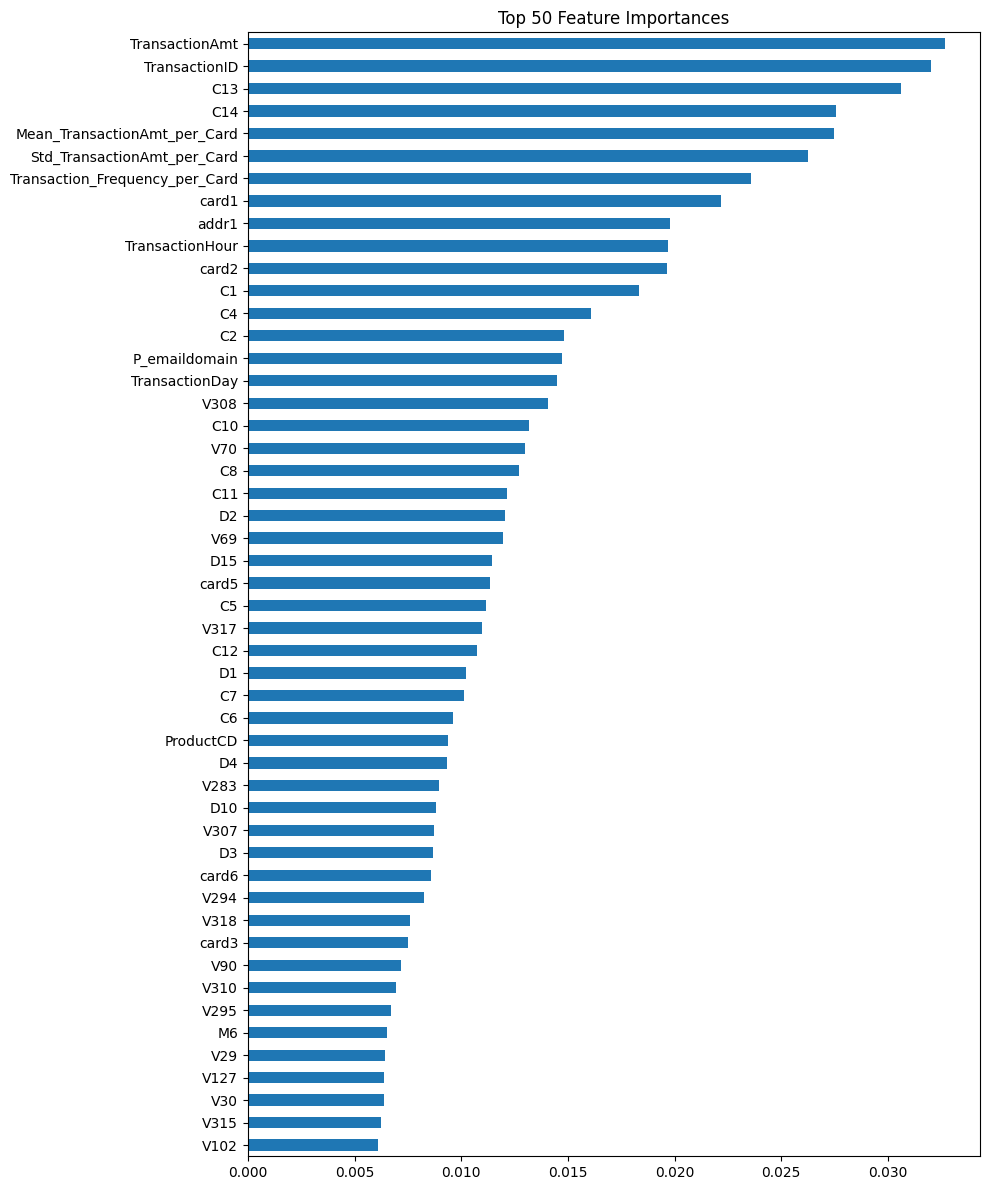

In [21]:
importances[top_features].sort_values().plot(kind='barh', figsize=(10, 12))
plt.title("Top 50 Feature Importances")
plt.tight_layout()
plt.show()


# Model Training

Logistic Regression

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_bal)

# Predict on test data
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]


Evaluation

In [31]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[83725 30250]
 [ 1089  3044]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    113975
           1       0.09      0.74      0.16      4133

    accuracy                           0.73    118108
   macro avg       0.54      0.74      0.50    118108
weighted avg       0.96      0.73      0.82    118108


ROC-AUC Score:
0.8077561866364099


In [32]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt


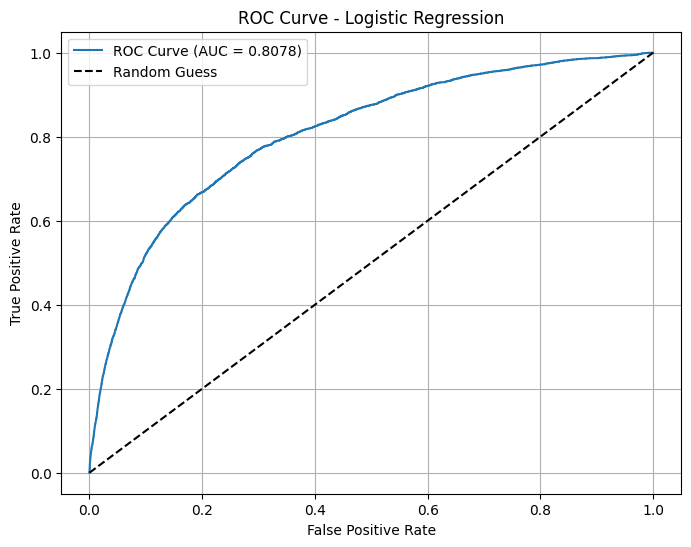

In [33]:
# Compute ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


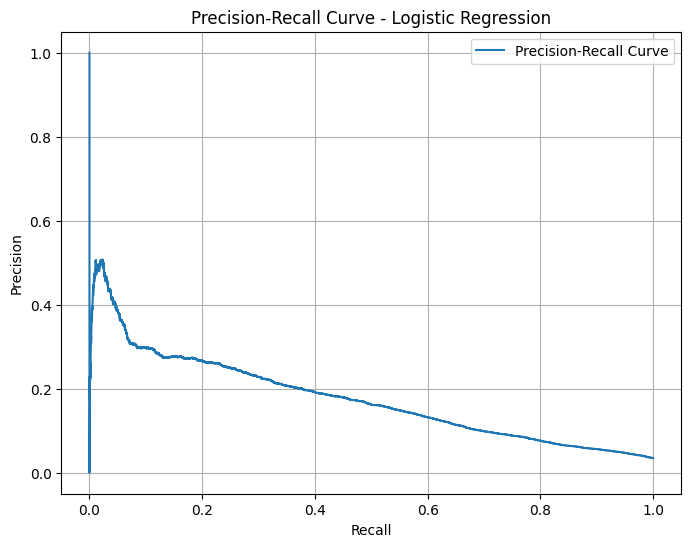

In [34]:
# Compute Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()
